# **OCT: Optical Coherence Tomography - Eyes Diseases Diagnosis**
### **Abdallah Fekry**
**Model 15**

---

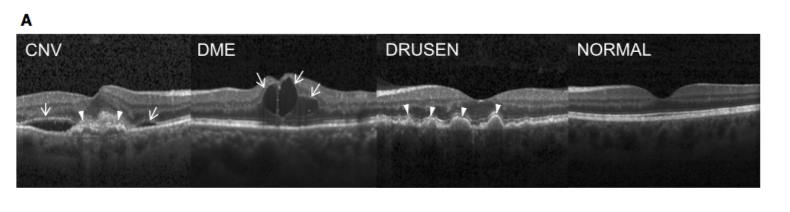

---
class 0 = CNV

class 1 = DME

class 2 = Drusen

class 3 = Normal

In [1]:
!pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import keras
keras.__version__

'2.15.0'

In [4]:
classes = {0 : 'CNV',
           1 : 'DME',
           2 : 'Drusen',
           3 : 'Normal'}

In [5]:
classes[0]

'CNV'

importing libraries

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential
from keras.layers import Dense,Input,Flatten
from tensorflow.keras.utils import load_img,img_to_array
from sklearn.metrics import confusion_matrix

In [6]:
import os
os.listdir('/kaggle/input/kermany2018/OCT2017 /train')

['DRUSEN', 'CNV', 'NORMAL', 'DME']

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_data = train_datagen.flow_from_directory('/kaggle/input/kermany2018/OCT2017 /train',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')
test_data = train_datagen.flow_from_directory('/kaggle/input/kermany2018/OCT2017 /train',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False,
                                              subset='validation')

Found 75138 images belonging to 4 classes.
Found 8346 images belonging to 4 classes.


In [8]:
train_data.image_shape

(224, 224, 3)

In [9]:
np.unique(test_data.labels)

array([0, 1, 2, 3], dtype=int32)

In [10]:
train_data.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

---

# **Modeling**

## VGG 16 Architecture

In [29]:
vgg16_model = vgg16.VGG16(include_top=False, input_shape=(224,224,3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
for layer in vgg16_model.layers[:]:
  layer.trainable = False
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_4 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 4)                 16388     
                                                                 
Total params: 134276932 (512.23 MB)
Trainable params: 

In [32]:
len(train_data.labels)

75138

In [72]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

results = model.fit(train_data, epochs=30, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks=EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
                  )

Epoch 1/30
2349/2349 [==============================] - 418s 177ms/step - loss: 0.1873 - accuracy: 0.9335 - val_loss: 0.4190 - val_accuracy: 0.8610
Epoch 2/30
2349/2349 [==============================] - 411s 175ms/step - loss: 0.1727 - accuracy: 0.9380 - val_loss: 0.3981 - val_accuracy: 0.8831
Epoch 3/30
2349/2349 [==============================] - 409s 174ms/step - loss: 0.1639 - accuracy: 0.9417 - val_loss: 0.4069 - val_accuracy: 0.8634
Epoch 4/30
2349/2349 [==============================] - 410s 174ms/step - loss: 0.1549 - accuracy: 0.9439 - val_loss: 0.4314 - val_accuracy: 0.8840
Epoch 5/30
2349/2349 [==============================] - 412s 175ms/step - loss: 0.1485 - accuracy: 0.9478 - val_loss: 0.3833 - val_accuracy: 0.8803
Epoch 6/30
2349/2349 [==============================] - 410s 175ms/step - loss: 0.1495 - accuracy: 0.9460 - val_loss: 0.4404 - val_accuracy: 0.8714
Epoch 7/30
2349/2349 [==============================] - 409s 174ms/step - loss: 0.1391 - accuracy: 0.9508 - val_

In [74]:
loss, acc = model.evaluate(test_data)

261/261 [==============================] - 36s 137ms/step - loss: 0.4314 - accuracy: 0.8840


In [120]:
print("VGG 16")
print('Test accuracy = ',round(acc*100,2),'%\nLoss = ',loss ,sep='')

VGG 16
Test accuracy = 88.4%
Loss = 0.43144991993904114


In [76]:
results.history['val_loss']

[0.41895973682403564,
 0.3980792462825775,
 0.4069121181964874,
 0.43144991993904114,
 0.383288711309433,
 0.44042184948921204,
 0.4195965528488159,
 0.44617512822151184,
 0.4782707691192627]

In [78]:
results.history['val_accuracy']

[0.861011266708374,
 0.8830577731132507,
 0.8634076118469238,
 0.8840162754058838,
 0.8803019523620605,
 0.8714354038238525,
 0.8828181028366089,
 0.8811406493186951,
 0.880901038646698]

In [79]:
i = results.history['val_loss'].index(loss)
i

3

In [80]:
results.history['val_accuracy'][i]

0.8840162754058838

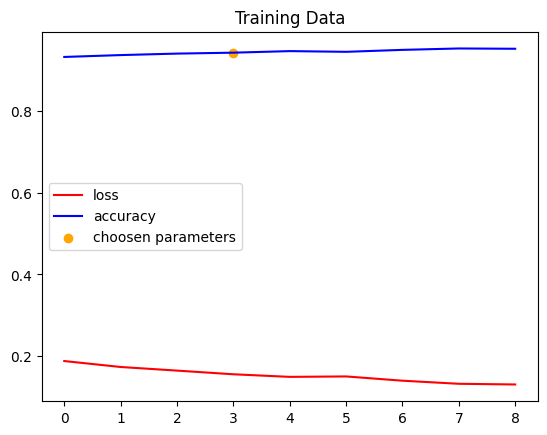

In [84]:
fig = plt.figure()
plt.plot(results.history['loss'], c='red', label='loss')
plt.plot(results.history['accuracy'], c='blue', label='accuracy')
plt.scatter(i ,results.history['accuracy'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Training Data")
plt.legend(loc="center left")
plt.show()

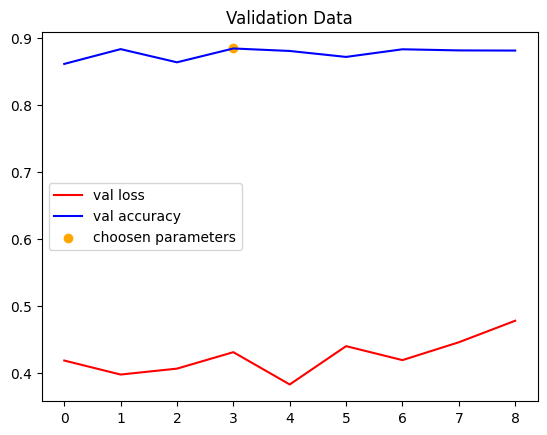

In [83]:
fig = plt.figure()
plt.plot(results.history['val_loss'], c='red', label='val loss')
plt.plot(results.history['val_accuracy'], c='blue', label='val accuracy')
plt.scatter(i ,results.history['val_accuracy'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Validation Data")
plt.legend(loc="center left")
plt.show()

---

# Inception v3 Architecture
(best accuracy)

In [109]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

In [115]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

x = base_model.output
x = AveragePooling2D()(x)
x = Dropout(.5)(x)
x = Flatten()(x)
x = Dense(4, kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005), activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=x)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 111, 111, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 111, 111, 32)         96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_28

In [116]:
opt = SGD(lr=.1, momentum=.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
from tensorflow.keras.callbacks import EarlyStopping
results2 = model2.fit(train_data, epochs=10, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks = EarlyStopping(patience=3, monitor='val_accuracy',restore_best_weights=True)
                  )

Epoch 1/10


2024-03-09 16:01:53.359990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2349/2349 [==============================] - 754s 312ms/step - loss: 0.2435 - accuracy: 0.9248 - val_loss: 0.2421 - val_accuracy: 0.9305
Epoch 2/10
2349/2349 [==============================] - 685s 291ms/step - loss: 0.1266 - accuracy: 0.9607 - val_loss: 0.2411 - val_accuracy: 0.9277
Epoch 3/10
2349/2349 [==============================] - 683s 291ms/step - loss: 0.1070 - accuracy: 0.9668 - val_loss: 0.1990 - val_accuracy: 0.9490
Epoch 4/10
2349/2349 [==============================] - 686s 292ms/step - loss: 0.0758 - accuracy: 0.9758 - val_loss: 0.1719 - val_accuracy: 0.9488
Epoch 5/10
2349/2349 [==============================] - 685s 292ms/step - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.2617 - val_accuracy: 0.9327
Epoch 6/10
2349/2349 [==============================] - 684s 291ms/step - loss: 0.1186 - accuracy: 0.9619 - val_loss: 0.2169 - val_accuracy: 0.9375


In [122]:
loss2, acc2 = model2.evaluate(test_data)

261/261 [==============================] - 30s 115ms/step - loss: 0.1990 - accuracy: 0.9490


In [123]:
print("Inception v3")
print("Test Accuracy:",round(acc2*100,2),"%","\nTest Loss:",loss2)

Inception v3
Test Accuracy: 94.9 % 
Test Loss: 0.19902732968330383


In [124]:
results2.history['val_loss']

[0.24212484061717987,
 0.2410910278558731,
 0.19902732968330383,
 0.17190727591514587,
 0.2617340683937073,
 0.21687792241573334]

In [125]:
results2.history['val_accuracy']

[0.930505633354187,
 0.9277498126029968,
 0.9489575624465942,
 0.9488377571105957,
 0.9326623678207397,
 0.9374550580978394]

In [126]:
i = results2.history['val_loss'].index(loss2)
i

2

In [127]:
results2.history['val_accuracy'][i]

0.9489575624465942

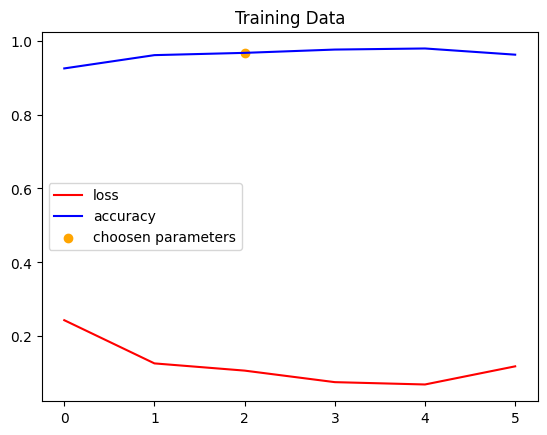

In [128]:
fig = plt.figure()
plt.plot(results2.history['loss'], c='red', label='loss')
plt.plot(results2.history['accuracy'], c='blue', label='accuracy')
plt.scatter(i ,results2.history['accuracy'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Training Data")
plt.legend(loc="center left")
plt.show()

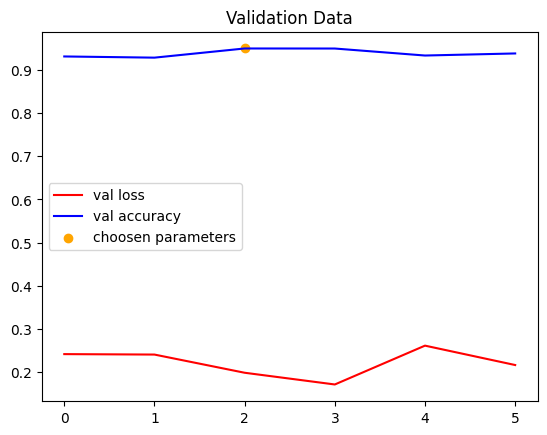

In [129]:
fig = plt.figure()
plt.plot(results2.history['val_loss'], c='red', label='val loss')
plt.plot(results2.history['val_accuracy'], c='blue', label='val accuracy')
plt.scatter(i ,results2.history['val_accuracy'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Validation Data")
plt.legend(loc="center left")
plt.show()

---

In [130]:
yp = model2.predict(test_data)
yp

261/261 [==============================] - 33s 120ms/step


array([[9.9979573e-01, 3.3236265e-05, 1.6490699e-04, 6.1141782e-06],
       [9.9999666e-01, 3.3416704e-06, 6.7162458e-09, 1.2043633e-09],
       [9.7708499e-01, 7.0822099e-03, 1.4852667e-02, 9.8016334e-04],
       ...,
       [1.1325133e-08, 2.0663572e-06, 3.4090900e-04, 9.9965703e-01],
       [8.5411109e-09, 9.5840267e-07, 1.5720091e-04, 9.9984181e-01],
       [8.4024350e-11, 1.5615747e-07, 6.8055648e-05, 9.9993181e-01]],
      dtype=float32)

In [131]:
yp = yp.argmax(axis=1)
yp

array([0, 0, 0, ..., 3, 3, 3])

In [132]:
yp.shape

(8346,)

Text(0.5, 1.0, 'CNV Sample')

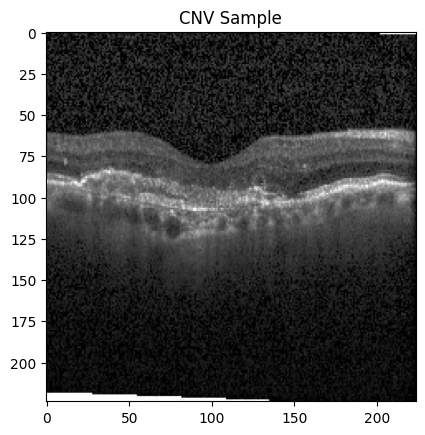

In [133]:
cnv = load_img('/kaggle/input/kermany2018/OCT2017 /test/CNV/CNV-1016042-1.jpeg',target_size=(224,224))
plt.imshow(cnv)
plt.title('CNV Sample')

Text(0.5, 1.0, 'DME Sample')

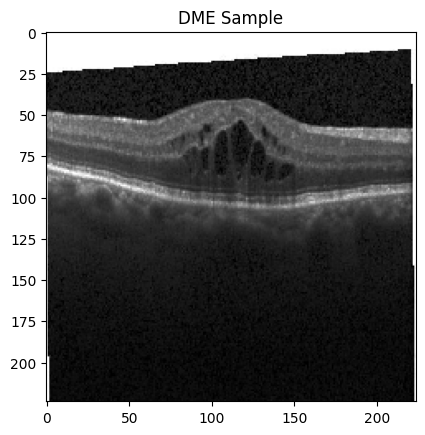

In [134]:
dme = load_img('/kaggle/input/kermany2018/OCT2017 /test/DME/DME-1081406-1.jpeg',target_size=(224,224))
plt.imshow(dme)
plt.title('DME Sample')

Text(0.5, 1.0, 'Drusen Sample')

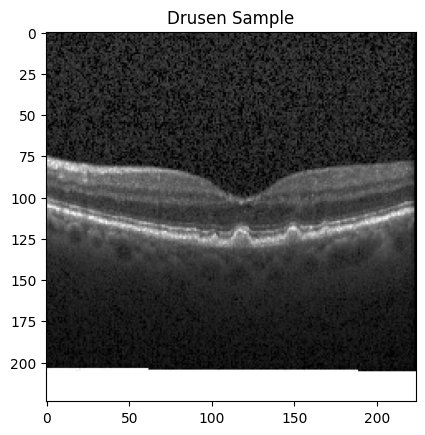

In [135]:
dru = load_img('/kaggle/input/kermany2018/OCT2017 /test/DRUSEN/DRUSEN-1083159-1.jpeg',target_size=(224,224))
plt.imshow(dru)
plt.title('Drusen Sample')

Text(0.5, 1.0, 'Normal Sample')

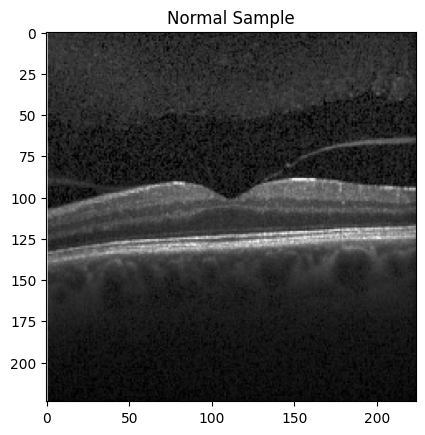

In [136]:
n = load_img('/kaggle/input/kermany2018/OCT2017 /test/NORMAL/NORMAL-1017237-1.jpeg',target_size=(224,224))
plt.imshow(n)
plt.title('Normal Sample')

Text(0.5, 1.0, 'Normal')

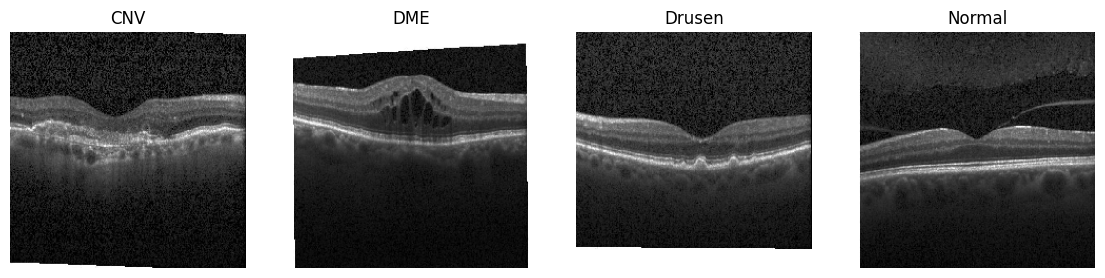

In [137]:
fig = plt.figure(figsize=(14,7))
# plt.grid=False
fig.add_subplot(1, 4, 1)
plt.axis('off')
plt.imshow(cnv)
plt.title('CNV')
# _______________________________
fig.add_subplot(1, 4, 2)
plt.axis('off')
plt.imshow(dme)
plt.title('DME')
# _______________________________
fig.add_subplot(1, 4, 3)
plt.axis('off')
plt.imshow(dru)
plt.title('Drusen')
# _______________________________
fig.add_subplot(1, 4, 4)
plt.axis('off')
plt.imshow(n)
plt.title('Normal')

In [138]:
cnv = img_to_array(cnv)
n = img_to_array(n)
dme = img_to_array(dme)
dru = img_to_array(dru)
cnv = cnv/255
n = n/255
dme = dme/255
dru = dru/255
cnv = cnv.reshape(1,224,224,3)
n = n.reshape(1,224,224,3)
dme = dme.reshape(1,224,224,3)
dru = dru.reshape(1,224,224,3)
cnv.shape

(1, 224, 224, 3)

In [139]:
p1 = model2.predict(cnv).argmax()
print("Actual: CNV")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 3s 3s/step
Actual: CNV
Predicted: Class 0: CNV


In [140]:
p1 = model2.predict(dme).argmax()
print("Actual: DME")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 0s 28ms/step
Actual: DME
Predicted: Class 1: DME


In [141]:
p1 = model2.predict(dru).argmax()
print("Actual: Drusen")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 0s 24ms/step
Actual: Drusen
Predicted: Class 2: Drusen


In [142]:
p1 = model2.predict(n).argmax()
print("Actual: Normal")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 0s 26ms/step
Actual: Normal
Predicted: Class 3: Normal


In [143]:
df = pd.DataFrame({'filename':test_data.filenames,'y_actual':test_data.classes,'Y_pred':yp})
df

,filename,y_actual,Y_pred
0,CNV/CNV-1016042-1.jpeg,0,0
1,CNV/CNV-1016042-10.jpeg,0,0
2,CNV/CNV-1016042-100.jpeg,0,0
3,CNV/CNV-1016042-101.jpeg,0,0
4,CNV/CNV-1016042-102.jpeg,0,0
...,...,...,...
8341,NORMAL/NORMAL-1938649-1.jpeg,3,3
8342,NORMAL/NORMAL-1938707-1.jpeg,3,3
8343,NORMAL/NORMAL-1939090-1.jpeg,3,3
8344,NORMAL/NORMAL-1939090-2.jpeg,3,3


In [99]:
test_data.labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [144]:
m = confusion_matrix(test_data.labels,yp)
m

array([[3651,   29,   28,   12],
       [  16, 1031,    6,   81],
       [ 110,    4,  691,   56],
       [  11,    5,   68, 2547]])

Heatmap



<Axes: xlabel='Predicted', ylabel='Actual'>

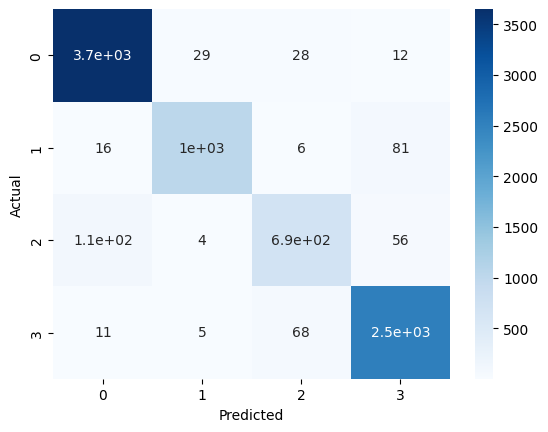

In [146]:
print("Heatmap\n")
m = pd.crosstab(test_data.labels, yp, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(m,annot=True, cmap='Blues')

---

In [147]:
model2.save('oct_model_Inception.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [148]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'oct_model_Inception.h5')

/kaggle/working


/kaggle/working/oct_model_Inception.h5